#semantic segmentation

In semantic segmentation, each pixel is classified according to the class of the object it belongs to (e.g., road, car, pedestrian, building, etc.), as shown in the Figure 

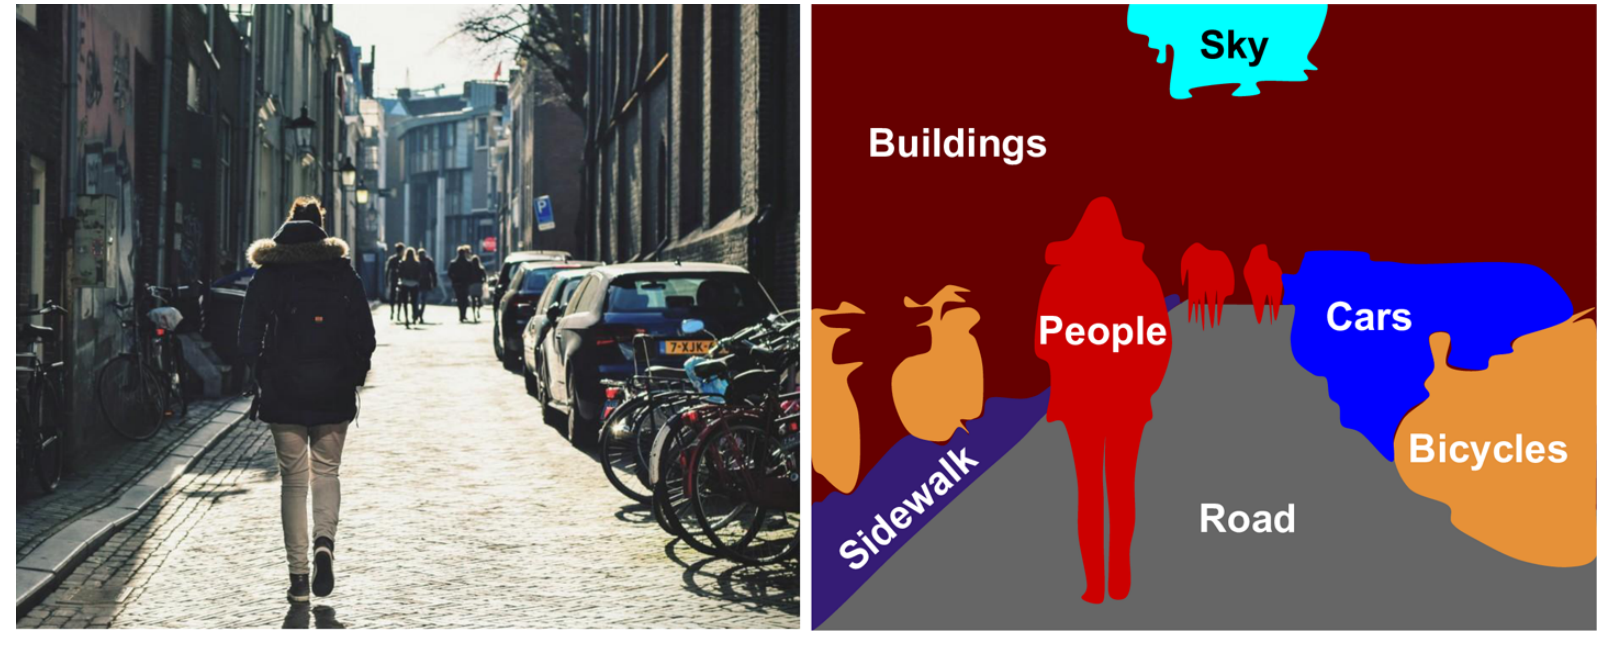



Note that different objects of the same class are not distinguished. For example, all the bicycles on the right side of the segmented image end up as one big lump of pixels. 

Themain difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a
regular CNN may end up knowing that there’s a person somewhere in the bottom left of the image, but it will not be much more precise than that.


In [1]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import time
import glob 

#Downloading the data[link text](https:// [link text](https://))
https://arxiv.org/abs/1811.12596


We will use the Crowd Instance-level Human Parsing Dataset for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images. Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification. This dataset can be used for the "human part segmentation" task.

In [2]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:19<00:00, 152MB/s]


#read the images paths


In [39]:
#create a function that get the floder path that contains the images 
#return a pandas dataframe that have the input images with there masks 
def create_dataset(folder_path,folder_type='Training'):
    images=sorted(glob.glob(folder_path+'/'+folder_type+'/Images/*.jpg'))#get the paths of images and sort them 
    masks=sorted(glob.glob(folder_path+'/'+folder_type+'/Category_ids/*.png'))#get the paths of mask and sort them 
    
    data={'images':images,'masks':masks}

    return pd.DataFrame(data)#return the pandas dataframe


train_data=create_dataset('/content/instance-level_human_parsing/instance-level_human_parsing')
val_data=create_dataset('/content/instance-level_human_parsing/instance-level_human_parsing','Validation')





val_data

,images,masks
0,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
1,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
2,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
3,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
...,...,...
4995,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4996,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4997,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4998,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...


In [4]:
NUM_CLASSES = 20 #number of class in mask images 


In [13]:
def read_image(x,y):
    #read_image function that work to read images from the paths
    #read image for x path
    
    x=tf.io.read_file(x)
    #decode the image to jpeg for x
    x=tf.image.decode_jpeg(x,channels=3)
    #This will convert to float values in [0, 1]for x
    x = tf.image.convert_image_dtype(x, tf.float32)
    #resize images to target model size for x
    x = tf.image.resize(x, [256, 256])
    #make sure the pixles value are between 0,1 for x
    x=tf.clip_by_value(x,clip_value_min=0,clip_value_max=1)


    #read image for y path
    y=tf.io.read_file(y)
    #decode the image to png for y

    y=tf.image.decode_png(y,channels=1)
   
    
    #resize images to target model size for y
    #note : when you resize the image using the NEAREST_NEIGHBOR method becose it keep the values of the pixles the same 
    y = tf.image.resize(y, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #reshape it from (256,256,1) to (256,256)
    y=tf.reshape(y,shape=(256,256))
    #create the one hot of y 
    y=tf.one_hot(y,depth=NUM_CLASSES)
    
    



    return x,y


def train_preprocess(x,y):
    #train_preprocess apply data augmentation from the training images 

    #data augmentation for x
    
    seed=np.random.randint(low=0,high=100,size=1)
    
    tf.compat.v1.set_random_seed(seed)
    x = tf.image.random_flip_left_right(x,seed=seed[0])

    x = tf.image.random_brightness(x, max_delta=32.0 / 255.0)
    x = tf.image.random_saturation(x, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    x = tf.clip_by_value(x, 0.0, 1.0)
    
    #it need to convert the y from the one hot to the normal image  we are using the argmax to do that 
    #note set the axis at the last axis 
    y=tf.argmax(y,axis=-1)
    #reshape it from (256,256) to (256,256,1) so can implement the flip
    y=tf.reshape(y,shape=(256,256,1))
    #randomly flip the mask but it should be the same seed for the image to
    y=tf.image.random_flip_left_right(y,seed=seed[0])
    #reshape it from  (256,256,1)to  (256,256) so we can do on hot on it again 
    y=tf.reshape(y,shape=(256,256))
    y=tf.one_hot(y,depth=NUM_CLASSES)
    
    
    
    
    

    






    return x,y




#creatte the data pipeline

In [14]:
#create the data pipline 
def dataset_creater(x,y,training=False):
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(1028,reshuffle_each_iteration=True)
    data=data.map(read_image,num_parallel_calls=tf.data.AUTOTUNE)#read images from paths 

    if training:
        #apply data augmentation 
        data=data.map(train_preprocess,num_parallel_calls=tf.data.AUTOTUNE)
    data=data.batch(32)
    data=data.prefetch(tf.data.AUTOTUNE)
    return data
#create the train data pipline
train_dataset=dataset_creater(train_data.images,train_data.masks,training=True) 
#create the test data pipline

test_dataset=dataset_creater(val_data.images,val_data.masks)   

    

#plot images 

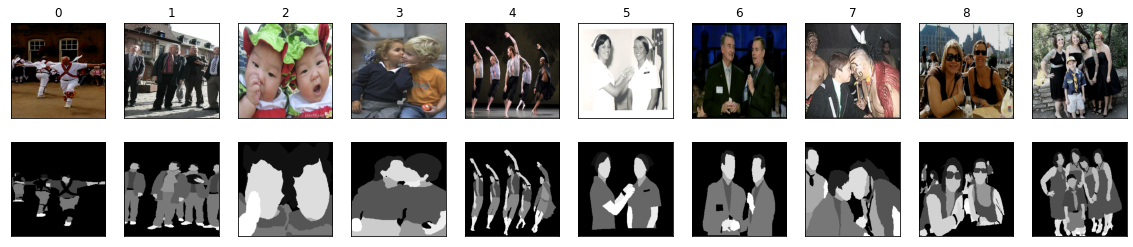

In [28]:
n = 10
plt.figure(figsize=(20, 4))

for x,y in train_dataset.take(1):



    for i in range(n):
        ax=plt.subplot(2, n, i + 1)
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    
        bx=plt.subplot(2, n, n+i + 1)

    
        
        plt.imshow(tf.squeeze(tf.argmax(y[i],-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

        


plt.show()

In [29]:
y.shape

TensorShape([32, 256, 256, 20])

In [30]:
set(y[0].numpy().reshape(-1))

{0.0, 1.0}

#Model 

##U-Net

U-Net is an architecture for semantic segmentation. It consists of a contracting path (encoder) and an expansive path (decoder). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a BatchNormalization than (Leaky_relu) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a BatchNormalization than (Leaky_relu). At the final layer a 1x1 convolution is used to map each 32-component feature vector to the desired number of classes. 

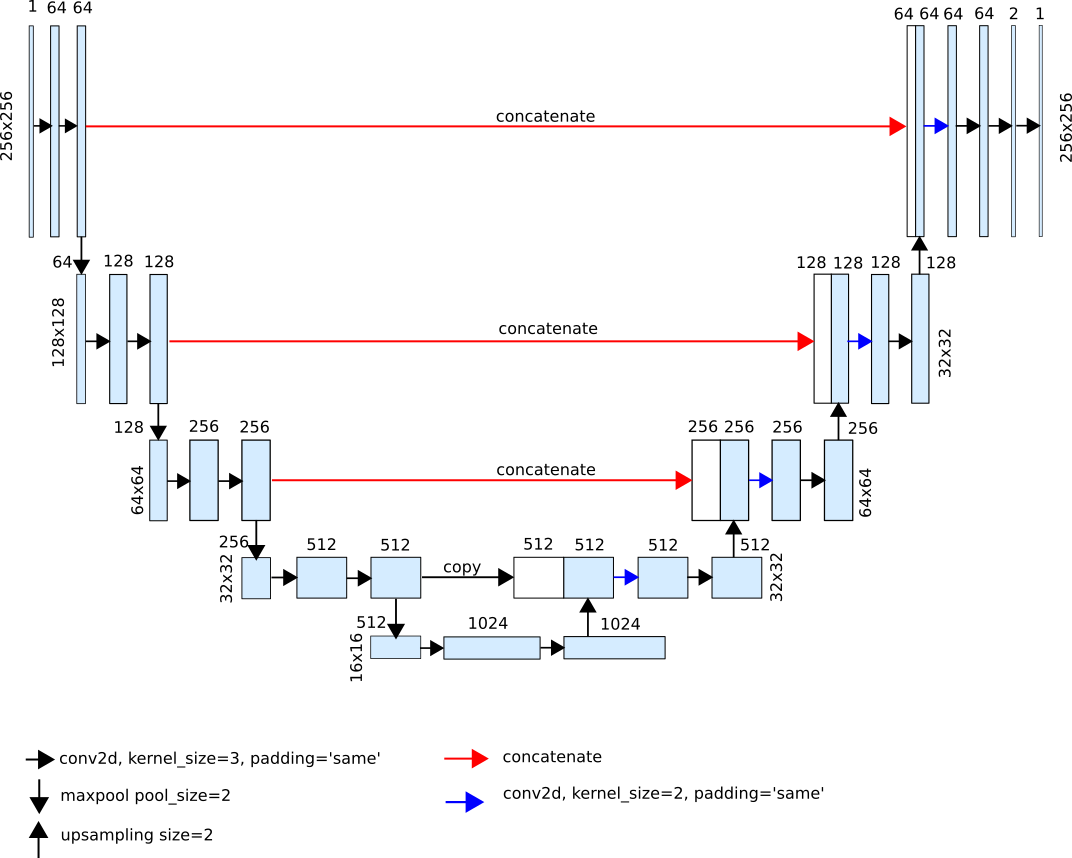

##Convolution Block 



In [31]:
class ConvBlock(tf.keras.layers.Layer):
    
    def __init__(self,filters):
        super(ConvBlock,self).__init__()

        self.Conv_1=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),padding='same',use_bias=False)
        self.BN_1=tf.keras.layers.BatchNormalization()

        self.Conv_2=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),padding='same',use_bias=False)
        self.BN_2=tf.keras.layers.BatchNormalization()
    def call(self,x):
        x=self.Conv_1(x)
        x=self.BN_1(x)
        x=tf.nn.leaky_relu(x)

        x=self.Conv_2(x)
        x=self.BN_2(x)
        x=tf.nn.leaky_relu(x)

        return x



##Encoder Block

In [32]:

class EncoderBloak(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(EncoderBloak,self).__init__()
        self.Conv_block=ConvBlock(filters)
        self.Max_pool=tf.keras.layers.MaxPooling2D()

    def call(self,x):
        x=self.Conv_block(x)
        p=self.Max_pool(x)
        return x,p

## decoder Block

In [33]:


class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(DecoderBlock,self).__init__()
        self.ConvTranspose=tf.keras.layers.Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2),padding='same')
        self.Conv_block=ConvBlock(filters)

    def call(self,input, skip_features):
        x=self.ConvTranspose(input)
        x=tf.keras.layers.concatenate([x,skip_features])
        x=self.Conv_block(x)
        return x



##the U-Net Model

In [34]:
class SemanticSegmentation(tf.keras.Model):
    def __init__(self,n_classes=NUM_CLASSES):
        super(SemanticSegmentation,self).__init__()

        self.encoder_bloak_1=EncoderBloak(32)
        self.encoder_bloak_2=EncoderBloak(64)
        self.encoder_bloak_3=EncoderBloak(128)
        self.encoder_bloak_4=EncoderBloak(256)
        self.encoder_bloak_5=EncoderBloak(512)
        self.conv_block_6=ConvBlock(1028)
        self.decoder_block_7=DecoderBlock(512)
        self.decoder_block_8=DecoderBlock(256)
        self.decoder_block_9=DecoderBlock(128)
        self.decoder_block_10=DecoderBlock(64)
        self.decoder_block_11=DecoderBlock(32)

        self.out = tf.keras.layers.Conv2D(n_classes,kernel_size=(1,1))




    def call(self,x):
        s1,x=self.encoder_bloak_1(x)
        s2,x=self.encoder_bloak_2(x)
        s3,x=self.encoder_bloak_3(x)
        s4,x=self.encoder_bloak_4(x)
        s5,x=self.encoder_bloak_5(x)
        x=self.conv_block_6(x)
        x=self.decoder_block_7(x,s5)
        x=self.decoder_block_8(x,s4)
        x=self.decoder_block_9(x,s3)
        x=self.decoder_block_10(x,s2)
        x=self.decoder_block_11(x,s1)
        x=self.out(x)
        x=tf.nn.softmax(x)





        return x
    def build_model(self,dim=(256,256,3)):
        x=tf.keras.layers.Input(dim)
        return tf.keras.Model(inputs=[x],outputs=[self.call(x)])

In [35]:
model=SemanticSegmentation()
model.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_bloak (EncoderBloak)   ((None, 256, 256, 3  10336       ['input_1[0][0]']                
                                2),                                                               
                                 (None, 128, 128, 3                                               
                                2))                                                               
                                                                                              

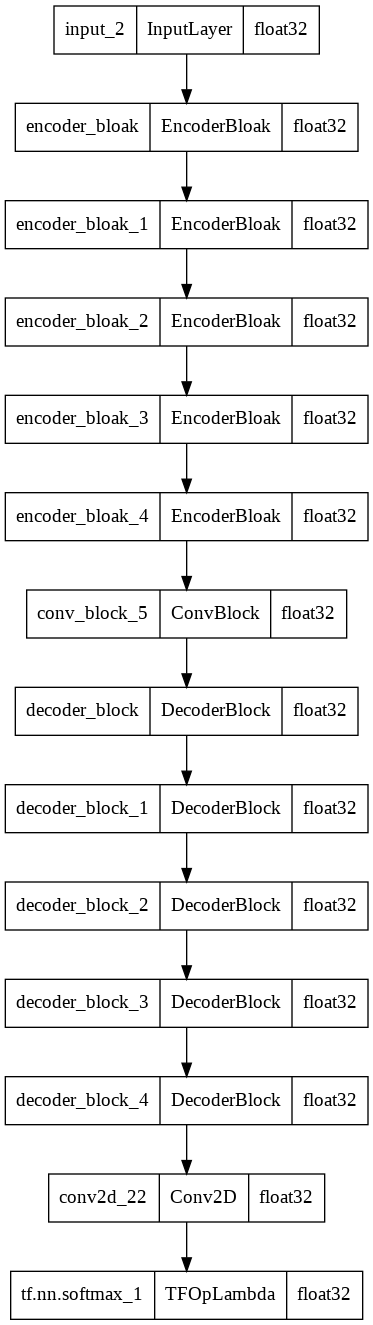

In [36]:
tf.keras.utils.plot_model(model.build_model(),show_dtype=True)

#define the Loss function and the optimizer

In [37]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

#train the model 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

#create the train function 
train step function has the GradientTape or automatic differentiation; that is, computing the gradient of a computation with respect to some inputs then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [41]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    #make prediction 
    predictions = model(x, training=True)
    #calculate the loss
    
    loss = loss_object(y, predictions)
  #  calculate the gradients 
  gradients = tape.gradient(loss, model.trainable_variables)
  #update the model trainable perimeters
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)

Test the model:

In [42]:
@tf.function
def test_step(x,y ):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(x, training=False)
  t_loss = loss_object(y, predictions)

  test_loss(t_loss)
  test_accuracy(y, predictions)

In [43]:
EPOCHS = 25

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  bar=tf.keras.utils.Progbar(len(val_data)+len(train_data))
  step=0
  for x, y in train_dataset:
    train_step(x,y)
    step=step+32
    bar.update(step)

  for x, y in test_dataset:
    test_step(x, y)
    step=step+32
    bar.update(step)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

  640/33280 [..............................] - ETA: 7:56

KeyboardInterrupt: ignored

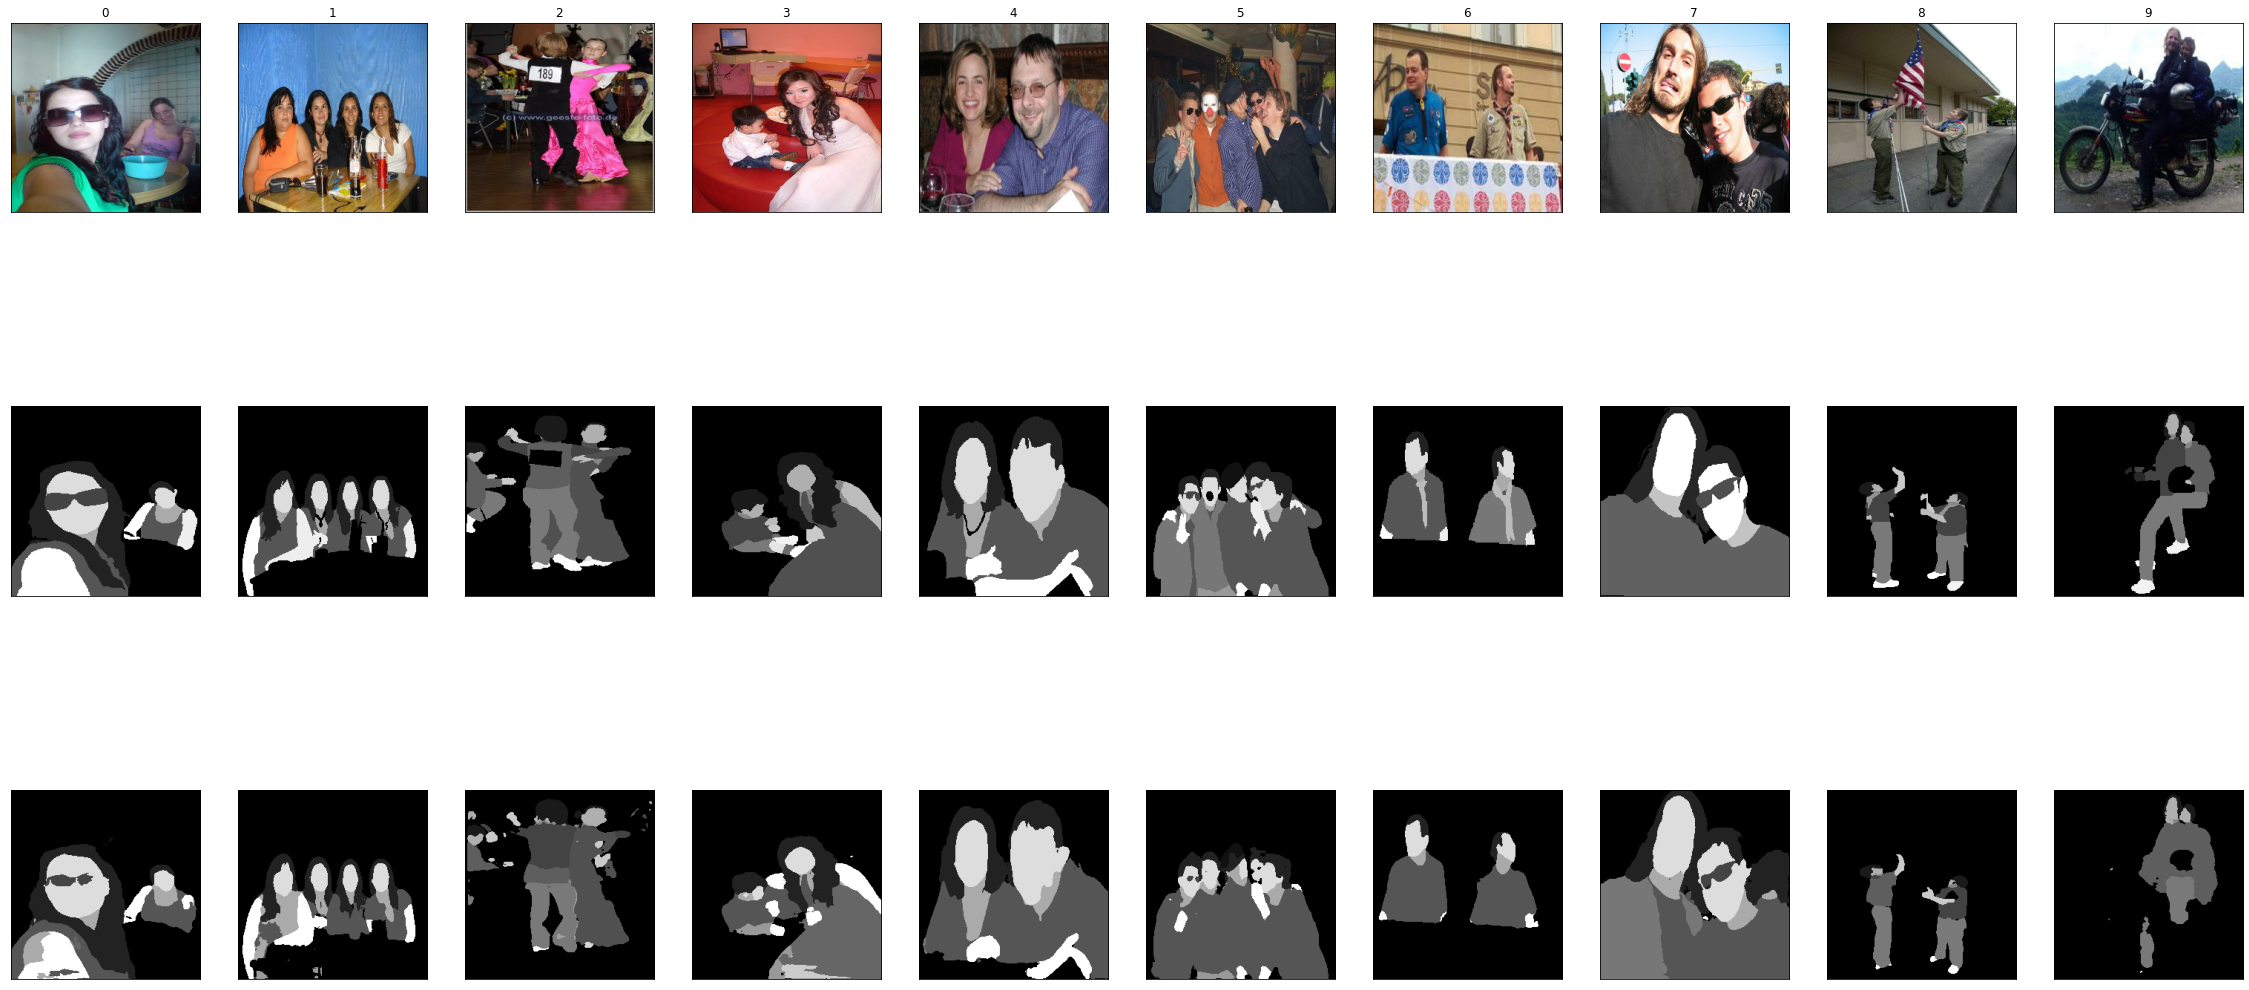

In [45]:
for x, y in test_dataset.take(1):
    pred=model(x,training=False)
    pred=tf.argmax(pred,axis=-1)
    n = 10
    plt.figure(figsize=(40, 20))


    for i in range(n):
        ax=plt.subplot(3, n, i + 1)
        
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    
        bx=plt.subplot(3, n, n+i + 1)
        
        plt.imshow(tf.squeeze(tf.argmax(y[i],axis=-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    
        cx=plt.subplot(3, n, n+i+n + 1)
        
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)

        


plt.show()
    